In [1]:
import librosa
import librosa.display
import os
import numpy as np
import torch
from torch import nn
import random

In [2]:
dataset_path = os.getenv("DL_DATASET")

In [3]:
dataset_path

'/media/mtb/nas/datasets/'

In [4]:
path = os.path.join(dataset_path, "Free Spoken Digit Dataset (FSDD)", "recordings")


In [5]:
files = sorted(os.listdir(path))

In [6]:
records = {}
for digit in range(0, 10):
    records[digit] = [os.path.join(path, f) for f in files if f[0] == str(digit)]

In [7]:
max_length = 1.5 # 1s

In [8]:
filename = records[0][0]
samples, sample_rate = librosa.load(filename)

In [9]:
sample_rate

22050

In [10]:
samples.shape

(6571,)

In [11]:
for digit in range(5):
    filename = records[digit][np.random.randint(0, 150)]
    samples, sample_rate = librosa.load(filename)
    print(samples, sample_rate, samples.shape)

[ 0.00362129  0.00073368 -0.00340068 ...  0.00037207  0.00025946
  0.        ] 22050 (12354,)
[ 0.00015859  0.00015921  0.00014748 ... -0.00032447 -0.00019537
  0.        ] 22050 (15692,)
[-0.00042124 -0.00030743 -0.00016569 ... -0.00050717 -0.00031351
  0.        ] 22050 (9438,)
[0.00199726 0.00308194 0.00348567 ... 0.00472449 0.00269703 0.        ] 22050 (9157,)
[0.0002389  0.00095187 0.00173984 ... 0.0027752  0.00145007 0.        ] 22050 (11183,)


In [12]:
samples, sample_rate, samples.shape

(array([0.0002389 , 0.00095187, 0.00173984, ..., 0.0027752 , 0.00145007,
        0.        ], dtype=float32),
 22050,
 (11183,))

In [13]:
short_samples = librosa.util.fix_length(samples, int(sample_rate * max_length))
short_samples.shape

/tmp/ipykernel_22440/833007516.py:1: FutureWarning: Pass size=33075 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  short_samples = librosa.util.fix_length(samples, int(sample_rate * max_length))


(33075,)

In [14]:
melSpectrum = librosa.feature.melspectrogram(short_samples, sr=sample_rate, n_mels=128)

/tmp/ipykernel_22440/1538198112.py:1: FutureWarning: Pass y=[0.0002389  0.00095187 0.00173984 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melSpectrum = librosa.feature.melspectrogram(short_samples, sr=sample_rate, n_mels=128)


In [15]:
import matplotlib.pyplot as plt

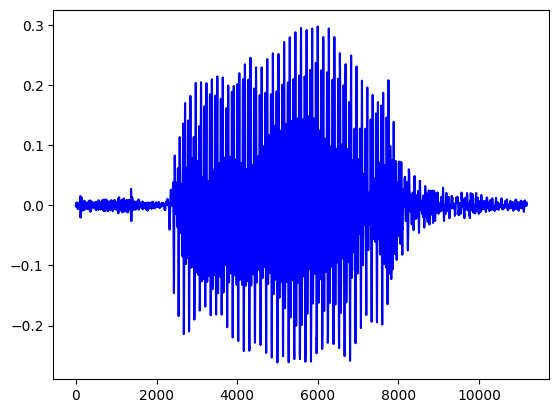

In [16]:
plt.plot(samples, label='samples', color='blue')

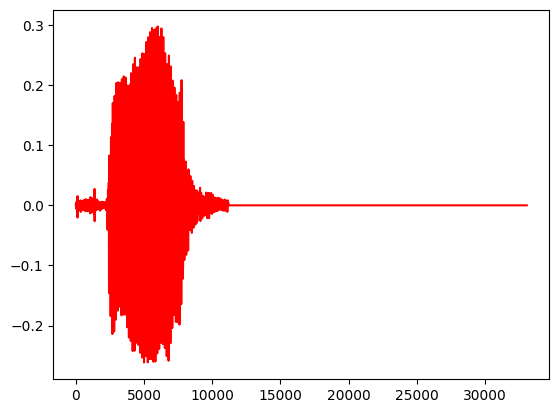

In [17]:
plt.plot(short_samples, label='short_samples', color='red')

In [18]:
melSpectrum

array([[1.49344742e-05, 8.34149887e-06, 2.62584444e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.42039935e-05, 3.88098124e-06, 9.55961994e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.01541018e-05, 2.68634312e-06, 3.63532791e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.24967509e-10, 3.14049793e-11, 1.18465803e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.12175630e-10, 2.82168594e-11, 6.98769955e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.04335887e-10, 2.62617306e-11, 7.16019847e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [19]:
logMelspectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
logMelspectrogram

array([[-72.743355, -75.27281 , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-72.96115 , -78.59584 , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-74.41884 , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

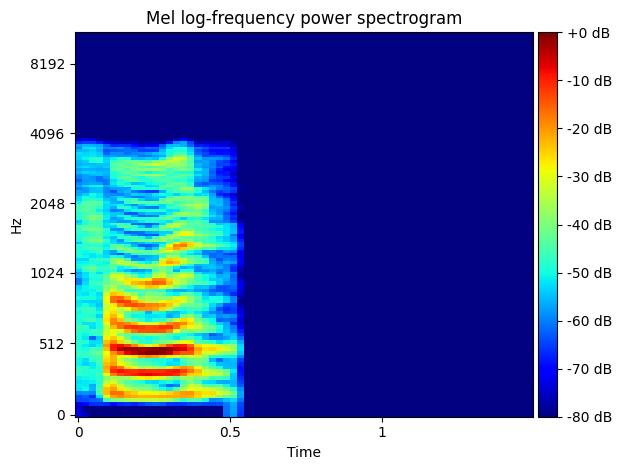

In [20]:
fig = plt.figure()
librosa.display.specshow(logMelspectrogram, sr=sample_rate, x_axis='time', y_axis='mel', cmap="jet")
plt.title('Mel log-frequency power spectrogram')
plt.colorbar(pad=0.01, format='%+02.0f dB')
plt.tight_layout()  

In [21]:
for digit in range(10):
    print(f"Lable {digit} Size: ({len(records[digit])})")

Lable 0 Size: (300)
Lable 1 Size: (300)
Lable 2 Size: (300)
Lable 3 Size: (300)
Lable 4 Size: (300)
Lable 5 Size: (300)
Lable 6 Size: (300)
Lable 7 Size: (300)
Lable 8 Size: (300)
Lable 9 Size: (300)


In [22]:
from torch.utils.data import DataLoader, Dataset


In [55]:
class Normalize():
    # Normalize between -1, 1
    def __init__(self, max_value=-80.) -> None:
        self.max = max_value
    
    def __call__(self, x):
        return(x + 80) / 80.

class TimePitchStretch():
    
    def __call__(self, x, sample_rate):
        ts = random.choice([0.75,1,1.25])
        ps = random.choice([-1,0,+1])
        x = librosa.effects.time_stretch(x, rate=ts)
        x = librosa.effects.pitch_shift(x, sr=sample_rate, n_steps=ps)
        return x
    
class Compose:
    
    def __init__(self, transforms) -> None:
        self.transforms = transforms
    
    def __call__(self, x, *args):
        for op in self.transforms:
            x = op(x, *args)
        return x

class FSDDDataset(Dataset):
    AUDIO_MAX_LENGTH = 1.5
    def __init__(self, path, transforms=None) -> None:
        self.path = path
        self.files = sorted(os.listdir(path))
        self.data = self.load()

        np.random.shuffle(self.data)
        self.transforms = transforms
        self.normalizer = Normalize()
        
    def __getitem__(self, index):
        label, audio_path = self.data[index]
        feature = self.process_audio(audio_path) # nmel, time
        feature = self.normalizer(feature)
        return feature, label
    
    def process_audio(self, filename):
        sample, sample_rate = librosa.load(filename)
        if self.transforms:
            sample = self._transform(sample, sample_rate) 
        short_sample = librosa.util.fix_length(sample, size=int(sample_rate * self.AUDIO_MAX_LENGTH))
        mel_spect = librosa.feature.melspectrogram(y=short_sample.astype(np.float32), sr=sample_rate, n_mels=128)
        log_mel_spect =  librosa.power_to_db(mel_spect, ref=np.max)
        return log_mel_spect

    def load(self):
        records = []
        for digit in range(0, 10):
            records.extend([(digit, os.path.join(self.path, f)) 
                            for f in self.files if f[0] == str(digit)])
        return records
    
    def __len__(self):
        return len(self.data)
    
    def _transform(self, feature, sample_rate):
        if np.random.random() < 0.8:
            return feature
        return self.transforms(feature, sample_rate)
            
        

In [56]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
dataset = FSDDDataset( os.path.join(dataset_path, "Free Spoken Digit Dataset (FSDD)", "recordings"), 
                      transforms=Compose([TimePitchStretch()]))
dataloader = DataLoader(dataset=dataset, batch_size=32, num_workers=8)

In [57]:
class Model(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.inp_size = 128 * 65
        fc1 = nn.Linear(128 * 65, 256)
        bn1 = nn.BatchNorm1d(256)
        relu1 = nn.ReLU()
        
        fc2 = nn.Linear(256, 128)
        bn2 = nn.BatchNorm1d(128)
        relu2 = nn.ReLU()
        
        # drop = nn.Dropout(p=0.2)
        
        out = nn.Linear(128, 10)
        
        self.net = nn.Sequential(
            fc1, bn1, relu1, 
            fc2, bn2, relu2, 
            out
        )
    
    def forward(self, x):
        x = x.view(-1, self.inp_size)
        x = self.net(x)
        return x

In [60]:
net = Model().cuda()
loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

In [61]:
NEPOCHS = 5
train_losses = []
epoch_loss = []

for epoch in range(NEPOCHS):
    for (x, y) in dataloader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = net(x)
        loss = loss_fn(out, y)
        loss.backward()
        train_losses.append(loss.item())
        print(epoch, loss)
        optimizer.step()


0 tensor(2.4781, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.3913, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.2683, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.1550, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.1465, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.9792, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.0368, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.9876, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.0437, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.8166, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.8780, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.8118, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.8300, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.6827, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.7644, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.5655, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor

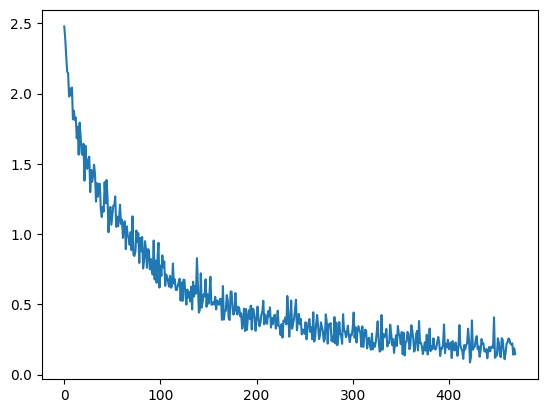

In [62]:
plt.plot(train_losses)

In [63]:
data = iter(dataloader)
x, y = next(data)

In [64]:
y.shape

torch.Size([32, 128, 65])

In [70]:
net.eval()
with torch.no_grad():
    y_pred = net(x.cuda())

In [72]:
torch.argmax(y_pred, dim=-1), y

(tensor([6, 3, 6, 0, 8, 3, 4, 7, 1, 8, 7, 0, 2, 5, 9, 3, 3, 1, 9, 8, 0, 0, 3, 6,
         4, 9, 8, 4, 0, 4, 3, 5], device='cuda:0'),
 tensor([6, 3, 6, 0, 8, 3, 4, 7, 1, 8, 7, 0, 2, 5, 9, 3, 3, 1, 9, 8, 0, 0, 3, 6,
         4, 9, 8, 4, 0, 4, 3, 5]))